In [1]:
import xarray as xr
import numpy as np
import qnt.stats as qnstats
import qnt.data as qndata
import qnt.output as qnout
import qnt.ta as qnta
import qnt.backtester as qnbt
import qnt.graph as qngraph
import qnt.exposure as qnexp
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import logging

In [2]:
# Cargar datos del S&P 500
snp_stocks_data = qndata.stocks_load_spx_data(min_date='2005-06-01')
# Seleccionar los 20 activos más líquidos
vol = snp_stocks_data.sel(field="vol")
liq = snp_stocks_data.sel(field="is_liquid")
close = snp_stocks_data.sel(field="close")
money_vol = vol * liq * close
total_money_vol = money_vol.sum(dim='time', skipna=True)
top_20_assets = total_money_vol.to_pandas().nlargest(20).index.tolist()
stock_data = snp_stocks_data.sel(asset=top_20_assets)

100% (367973 of 367973) |################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (79197 of 79197) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (13020216 of 13020216) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/13 1s


100% (13020220 of 13020220) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/13 2s


100% (13020216 of 13020216) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/13 3s


100% (13020220 of 13020220) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/13 4s


100% (13020188 of 13020188) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/13 5s


100% (13020108 of 13020108) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/13 7s


100% (13020108 of 13020108) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/13 8s


100% (12972804 of 12972804) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 8/13 9s


100% (13020108 of 13020108) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 9/13 10s


100% (13020108 of 13020108) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 10/13 12s


100% (13020108 of 13020108) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 11/13 13s


100% (13020108 of 13020108) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 12/13 14s


100% (7630032 of 7630032) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 13/13 14s
Data loaded 15s


In [3]:
def get_features(data):
    """Calculate technical indicators as features"""
    # Precios y volumen
    close = data.sel(field="close")
    high = data.sel(field="high")
    low = data.sel(field="low")
    vol = data.sel(field="vol")
    liq = data.sel(field="is_liquid")

    # Indicadores técnicos
    atrs = qnta.atr(high=high, low=low, close=close, ma=14)
    sma_20 = qnta.sma(close, 20)
    sma_50 = qnta.sma(close, 50)
    
    # Money flow indicators
    money_vol = vol * liq * close
    total_money_vol = money_vol.sum(dim='asset', skipna=True)
    money_vol_share = money_vol / total_money_vol
    mvs_mov = qnta.sma(money_vol_share, 135)
    
    # Ratio ATR/Close como en el ejemplo original
    ratio = atrs / close

    features = xr.concat([
        sma_20.assign_coords(field="sma20"),
        sma_50.assign_coords(field="sma50"),
        atrs.assign_coords(field="atr"),
        ratio.assign_coords(field="atr_ratio"),
        money_vol_share.assign_coords(field="money_vol_share"),
        mvs_mov.assign_coords(field="mvs_mov")
    ], dim="field")
    
    return features

# Calcular features
my_features = get_features(stock_data)

# Mostrar un resumen de los features
print("Dimensiones de los features:", my_features.dims)
print("\nPrimeros valores para un activo específico:")
print(my_features.isel(asset=0).to_pandas().head())
print("\nActivos disponibles:", my_features.asset.values)

Dimensiones de los features: ('field', 'time', 'asset')

Primeros valores para un activo específico:
time             2005-06-01  2005-06-02  2005-06-03  2005-06-06  2005-06-07  \
field                                                                         
sma20                   NaN         NaN         NaN         NaN         NaN   
sma50                   NaN         NaN         NaN         NaN         NaN   
atr                     NaN         NaN         NaN         NaN         NaN   
atr_ratio               NaN         NaN         NaN         NaN         NaN   
money_vol_share         NaN         NaN         NaN         NaN         NaN   

time             2005-06-08  2005-06-09  2005-06-10  2005-06-13  2005-06-14  \
field                                                                         
sma20                   NaN         NaN         NaN         NaN         NaN   
sma50                   NaN         NaN         NaN         NaN         NaN   
atr                     NaN  

In [4]:
def get_target_classes(data):
    """Define target values for ML prediction"""
    close = data.sel(field="close")
    future_close = qnta.shift(close, -1)  # Precio del siguiente día
    
    # Calcular retorno porcentual manualmente
    future_return = (future_close - close) / close
    
    # Clasificación multi-clase basada en los retornos
    target = xr.where(future_return > 0.02, 2,  # Strong up
             xr.where(future_return > 0, 1,     # Moderate up
             xr.where(future_return > -0.02, 0, # Sideways
             -1)))                              # Down
    
    return target

# Calcular targets
my_targetclass = get_target_classes(stock_data)

# Mostrar un resumen de los targets
print("Dimensiones de los targets:", my_targetclass.dims)
print("\nPrimeros valores para un activo específico:")
print(my_targetclass.isel(asset=0).to_pandas().head())

Dimensiones de los targets: ('time', 'asset')

Primeros valores para un activo específico:
time
2005-06-01   -1
2005-06-02   -1
2005-06-03    0
2005-06-06   -1
2005-06-07    1
dtype: int64


In [5]:
def get_model():
    """Constructor for Random Forest model"""
    return RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )

In [6]:
def train_models(features, targets):
    """Train models for each asset"""
    asset_name_all = features.coords["asset"].values
    models = {}
    scaler = StandardScaler()
    
    for asset_name in asset_name_all:
        try:
            # Preparar datos
            target_cur = targets.sel(asset=asset_name).dropna(dim="time", how="any")
            features_cur = features.sel(asset=asset_name).dropna(dim="time", how="any")
            
            # Alinear features y targets
            target_aligned, features_aligned = xr.align(target_cur, features_cur, join="inner")
            
            if len(features_aligned.time) < 10:
                logging.warning(f"Insufficient data for {asset_name}")
                continue
            
            # Preparar datos para el modelo
            features_array = features_aligned.transpose("time", "field").values
            target_array = target_aligned.values
            
            # Verificar que tenemos datos válidos
            if len(features_array) != len(target_array):
                logging.warning(f"Data mismatch for {asset_name}")
                continue
            
            # Escalado de características
            features_scaled = scaler.fit_transform(features_array)
                
            # Entrenar modelo
            model = get_model()
            model.fit(features_scaled, target_array)
            models[asset_name] = {
                'model': model,
                'scaler': scaler
            }
            
            print(f"Successfully trained model for {asset_name}")
            
        except Exception as e:
            logging.exception(f"Error training model for {asset_name}: {str(e)}")
    
    return models

# Entrenar modelos
print("Iniciando entrenamiento de modelos...")
models = train_models(my_features, my_targetclass)
print(f"Modelos entrenados: {len(models)}")

Iniciando entrenamiento de modelos...
Successfully trained model for NAS:AAPL
Successfully trained model for NAS:TSLA
Successfully trained model for NAS:NVDA
Successfully trained model for NAS:AMZN
Successfully trained model for NAS:MSFT
Successfully trained model for NAS:META
Successfully trained model for NAS:GOOGL
Successfully trained model for NAS:AMD
Successfully trained model for NYS:BAC
Successfully trained model for NYS:XOM
Successfully trained model for NAS:NFLX
Successfully trained model for NYS:JPM
Successfully trained model for NYS:C
Successfully trained model for NAS:GOOG
Successfully trained model for NAS:INTC
Successfully trained model for NYS:BA
Successfully trained model for NYS:WFC
Successfully trained model for NAS:CSCO
Successfully trained model for NYS:GS
Successfully trained model for NYS:JNJ
Modelos entrenados: 20



Importancia de características para NAS:AAPL:
atr_ratio: 0.24018
money_vol_share: 0.18850
atr: 0.16926
sma20: 0.14446
mvs_mov: 0.14206
sma50: 0.11553


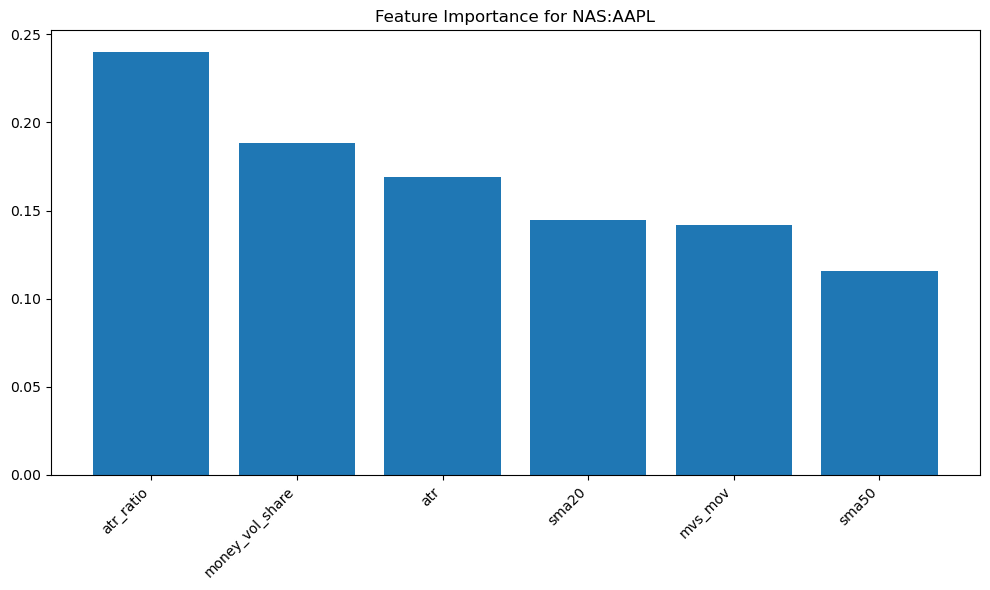


Importancia de características para NAS:TSLA:
money_vol_share: 0.23263
atr_ratio: 0.20014
mvs_mov: 0.16269
atr: 0.15115
sma50: 0.12725
sma20: 0.12613


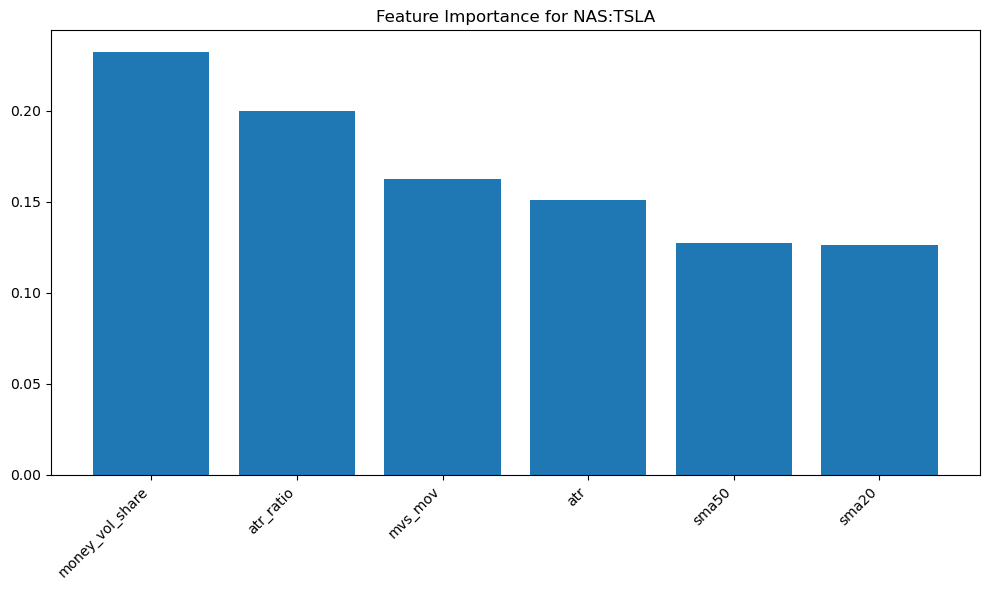


Importancia de características para NAS:NVDA:
atr_ratio: 0.23765
money_vol_share: 0.18063
sma20: 0.14942
sma50: 0.14890
atr: 0.14420
mvs_mov: 0.13921


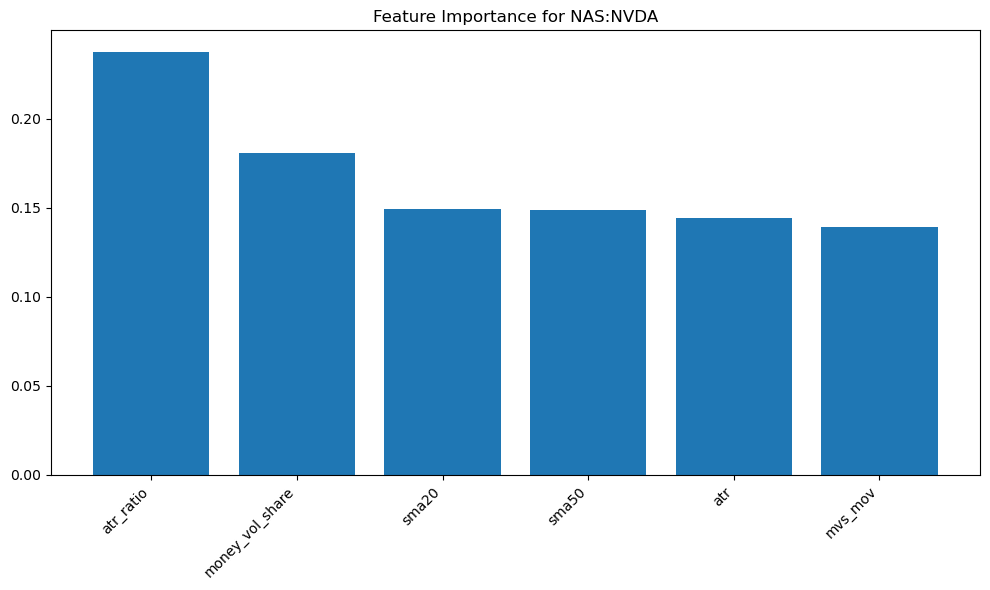


Importancia de características para NAS:AMZN:
atr_ratio: 0.25180
money_vol_share: 0.20362
atr: 0.15737
mvs_mov: 0.15422
sma20: 0.11863
sma50: 0.11436


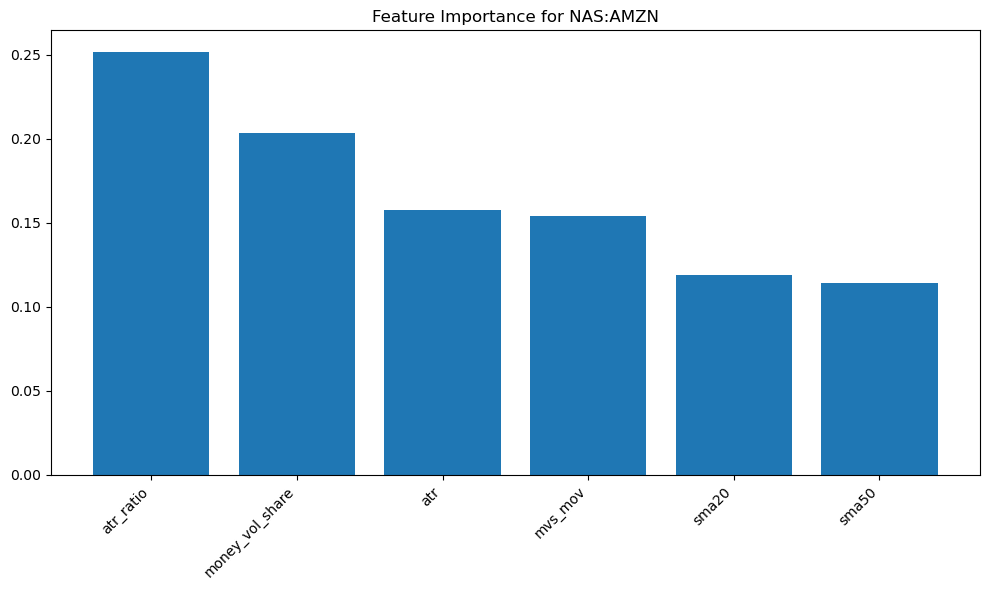


Importancia de características para NAS:MSFT:
atr_ratio: 0.25986
money_vol_share: 0.18445
atr: 0.14606
mvs_mov: 0.14385
sma50: 0.13920
sma20: 0.12657


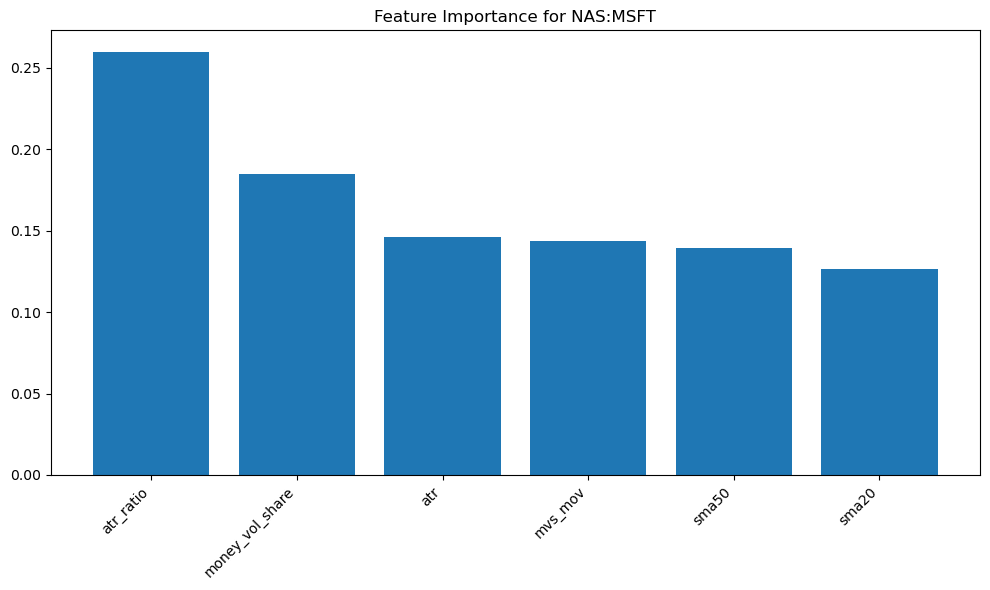


Importancia de características para NAS:META:
money_vol_share: 0.22579
atr_ratio: 0.20680
mvs_mov: 0.18403
atr: 0.14830
sma50: 0.12179
sma20: 0.11328


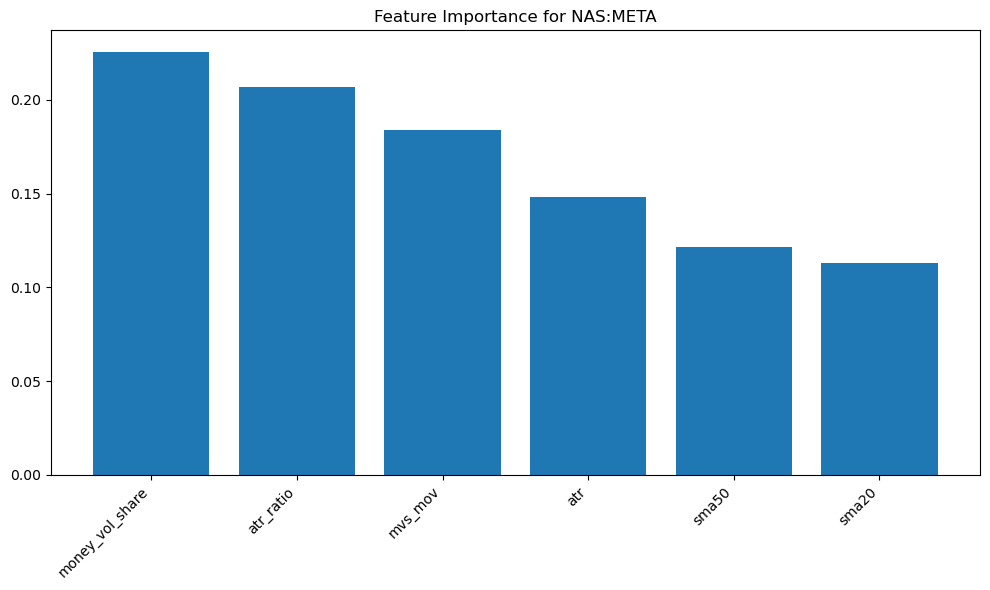


Importancia de características para NAS:GOOGL:
atr_ratio: 0.24308
money_vol_share: 0.21411
mvs_mov: 0.15995
atr: 0.14122
sma50: 0.12161
sma20: 0.12003


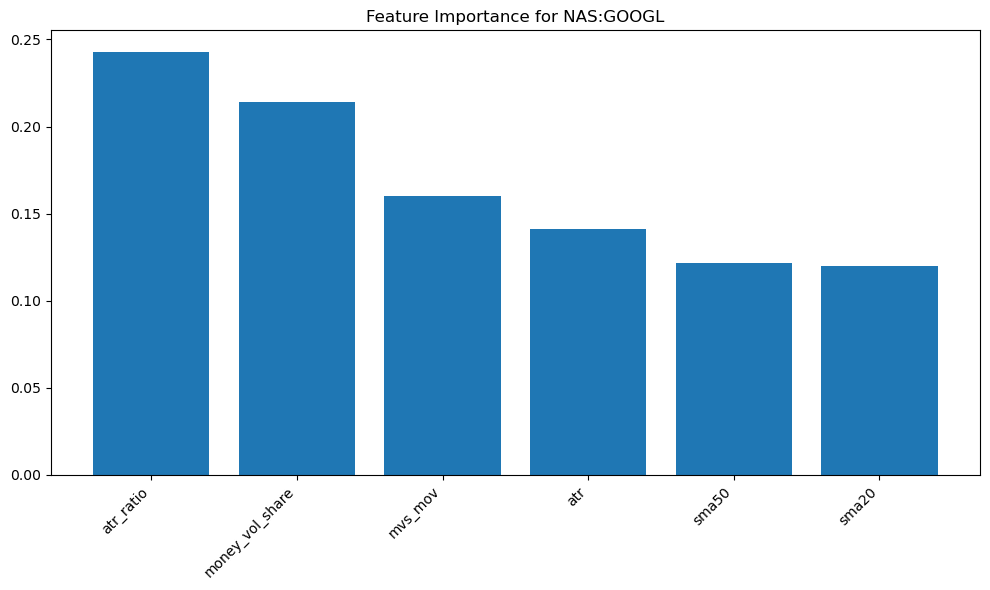


Importancia de características para NAS:AMD:
atr_ratio: 0.25218
money_vol_share: 0.19118
mvs_mov: 0.16234
atr: 0.13590
sma20: 0.13338
sma50: 0.12502


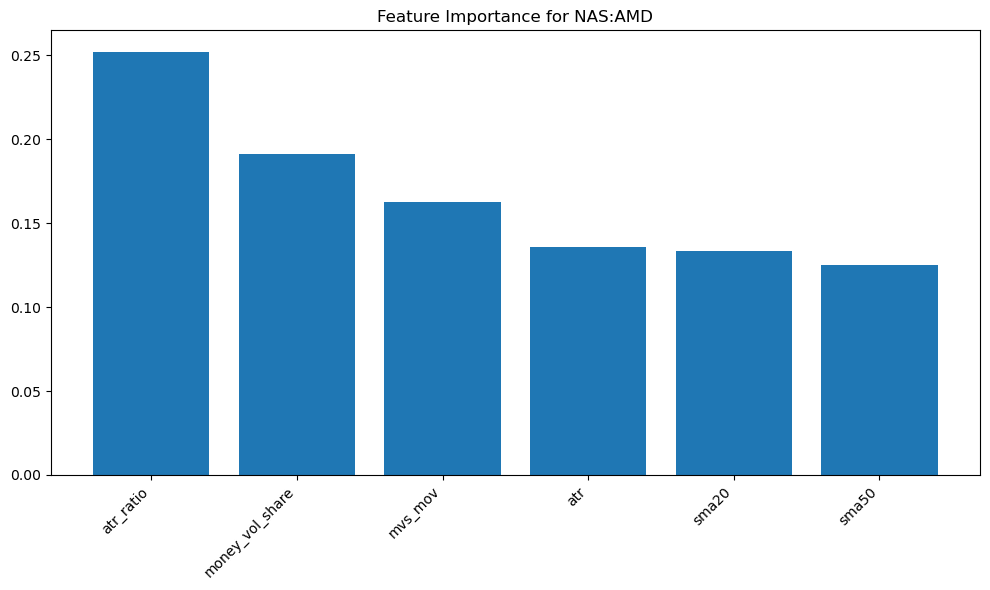


Importancia de características para NYS:BAC:
atr_ratio: 0.21834
atr: 0.18542
money_vol_share: 0.18442
sma50: 0.14509
sma20: 0.13501
mvs_mov: 0.13171


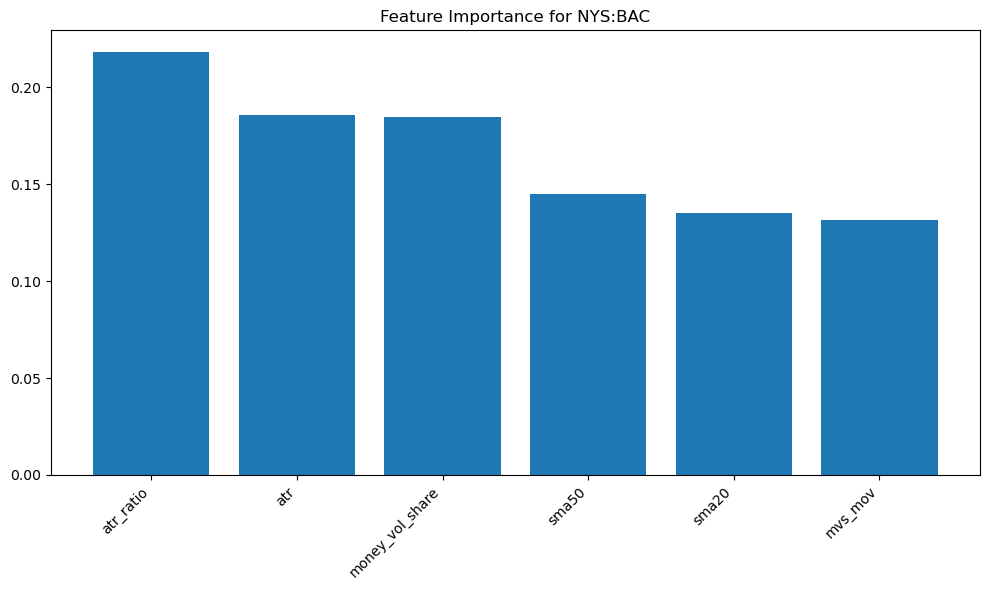


Importancia de características para NYS:XOM:
atr_ratio: 0.22005
money_vol_share: 0.18740
mvs_mov: 0.15710
atr: 0.15302
sma50: 0.15034
sma20: 0.13209


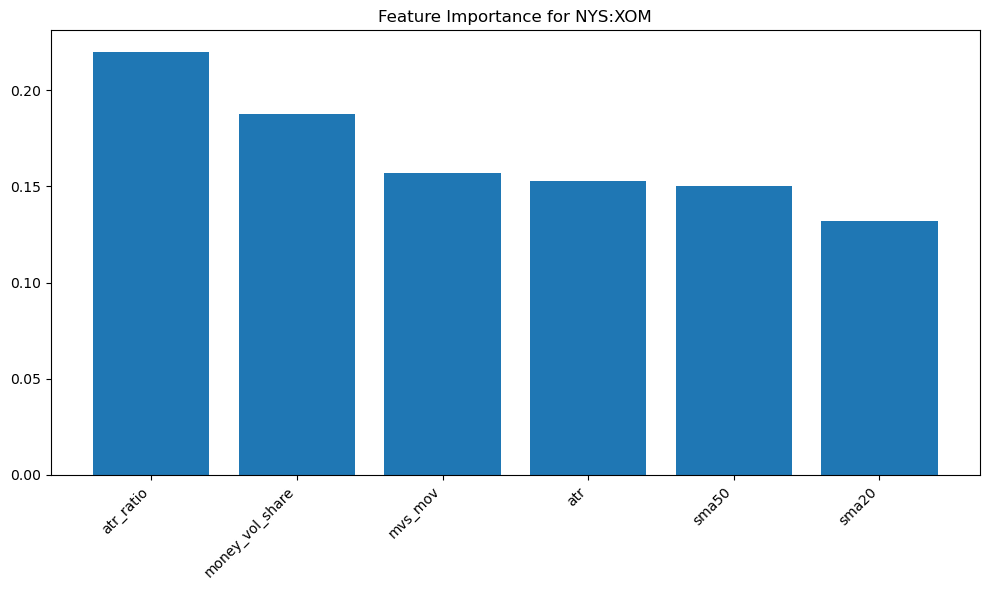


Importancia de características para NAS:NFLX:
atr_ratio: 0.23930
money_vol_share: 0.22986
mvs_mov: 0.17501
atr: 0.14108
sma20: 0.11123
sma50: 0.10352


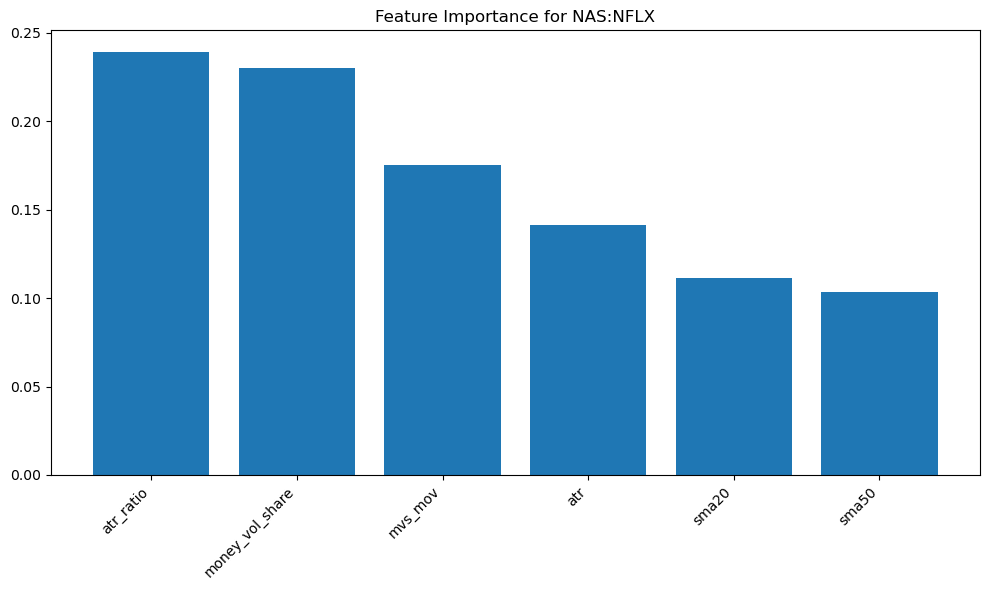


Importancia de características para NYS:JPM:
atr_ratio: 0.28384
money_vol_share: 0.20009
sma20: 0.13849
atr: 0.13726
mvs_mov: 0.13089
sma50: 0.10944


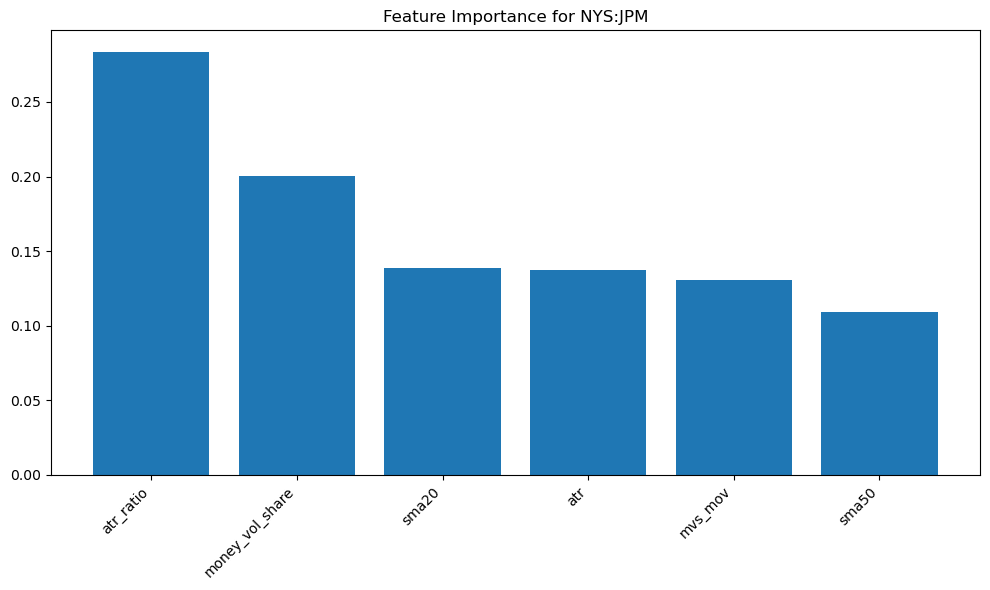


Importancia de características para NYS:C:
atr_ratio: 0.25396
atr: 0.18481
money_vol_share: 0.16588
sma20: 0.14387
mvs_mov: 0.13673
sma50: 0.11475


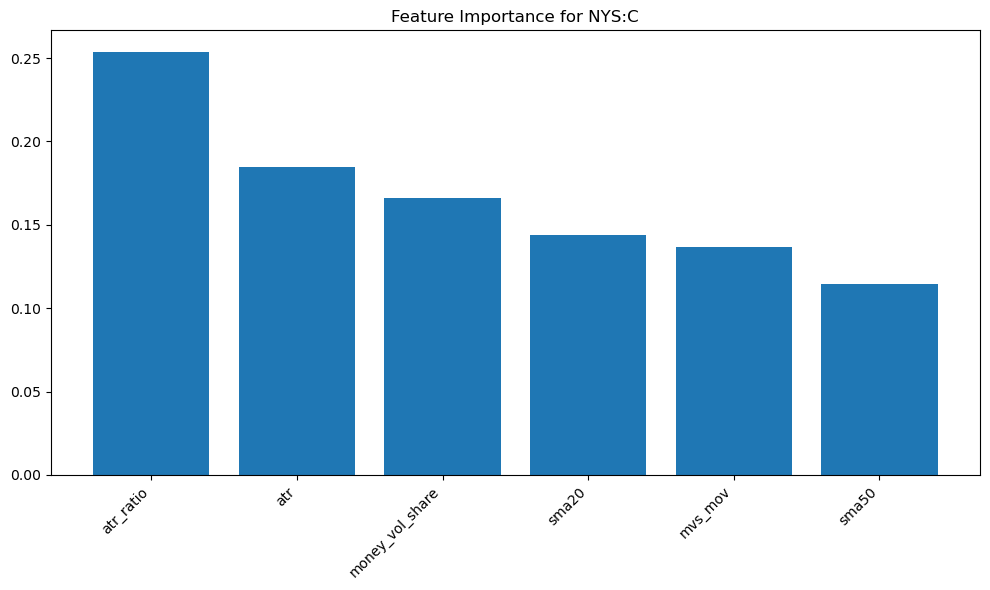


Importancia de características para NAS:GOOG:
money_vol_share: 0.25164
atr_ratio: 0.21568
atr: 0.16055
mvs_mov: 0.15469
sma20: 0.11494
sma50: 0.10251


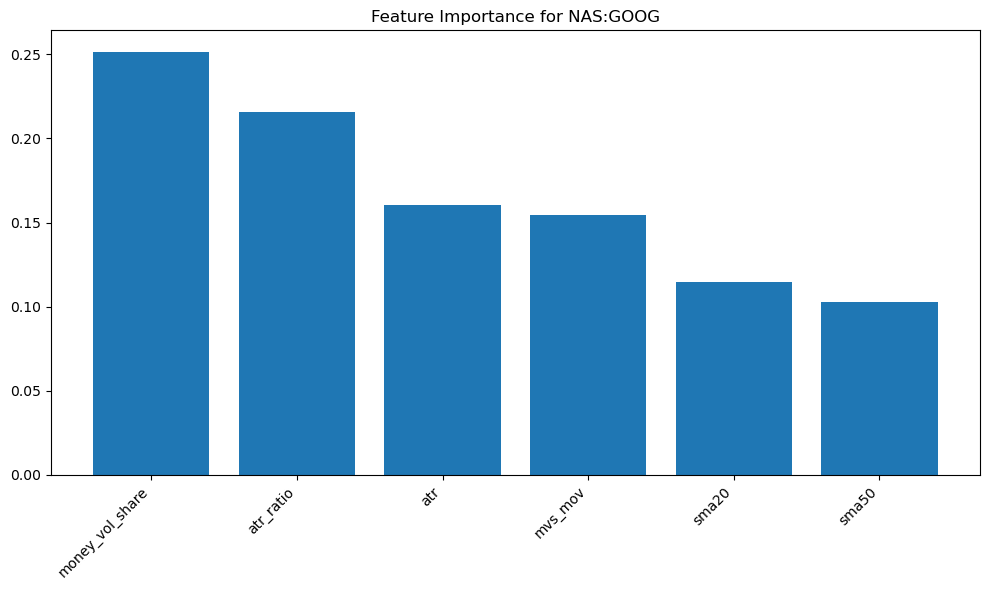


Importancia de características para NAS:INTC:
atr_ratio: 0.22531
money_vol_share: 0.18296
atr: 0.16947
mvs_mov: 0.14852
sma50: 0.13820
sma20: 0.13554


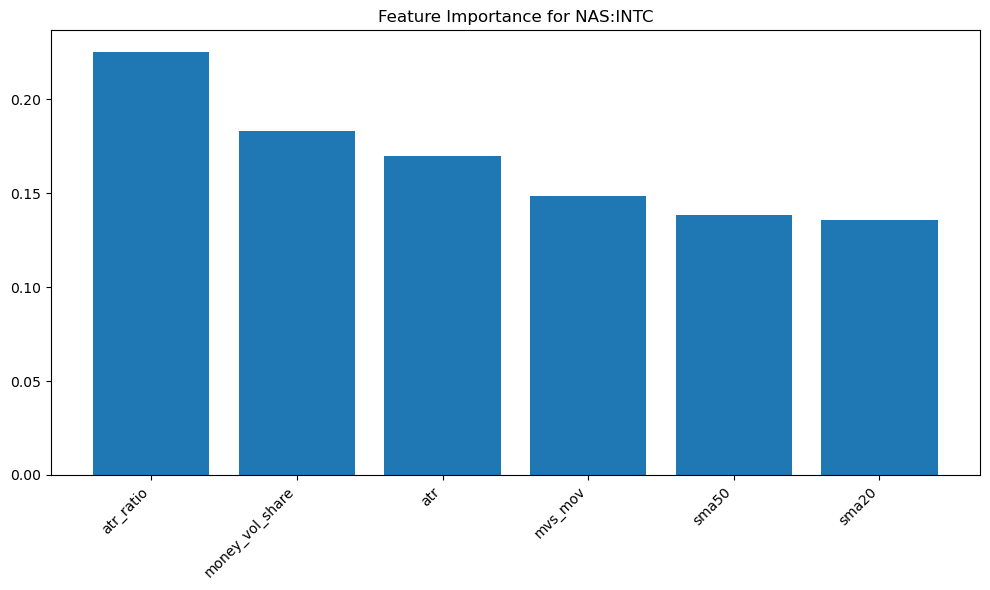


Importancia de características para NYS:BA:
atr_ratio: 0.20660
atr: 0.19912
money_vol_share: 0.17984
sma20: 0.14465
sma50: 0.13962
mvs_mov: 0.13016


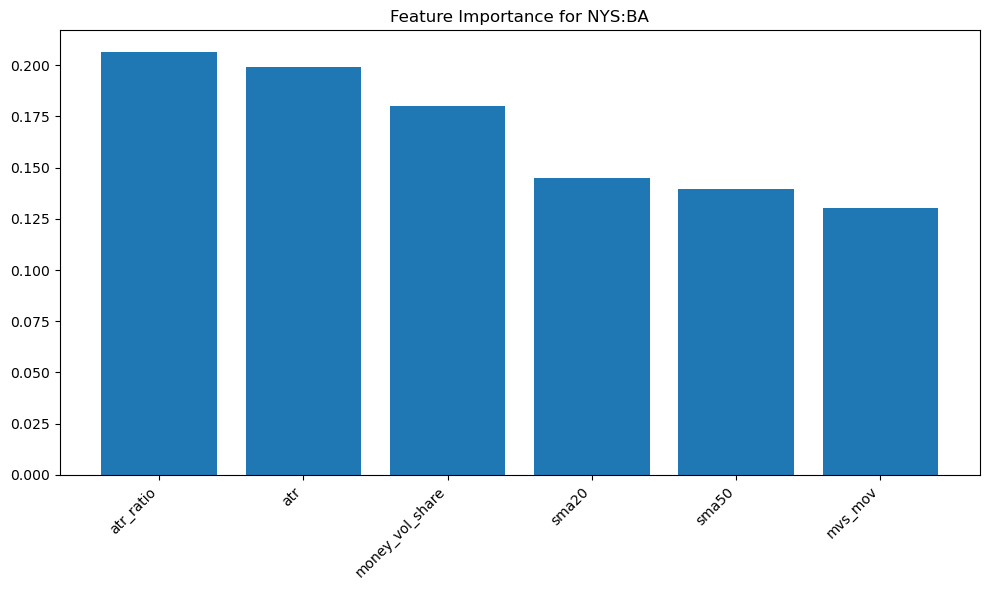


Importancia de características para NYS:WFC:
atr_ratio: 0.22761
atr: 0.20756
money_vol_share: 0.19811
sma20: 0.13354
mvs_mov: 0.11747
sma50: 0.11571


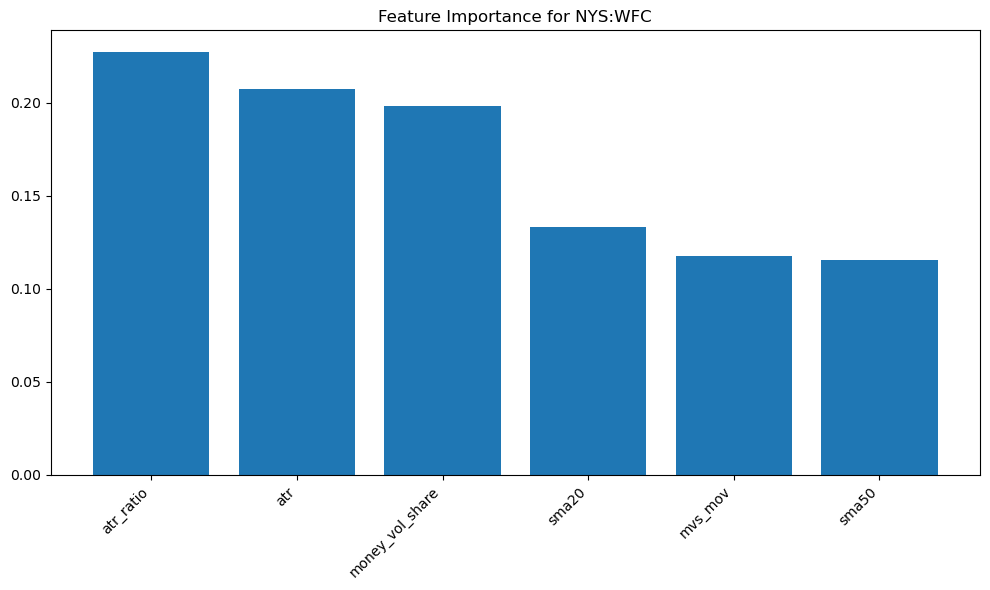


Importancia de características para NAS:CSCO:
atr_ratio: 0.24280
atr: 0.18440
money_vol_share: 0.16740
mvs_mov: 0.14429
sma20: 0.14060
sma50: 0.12052


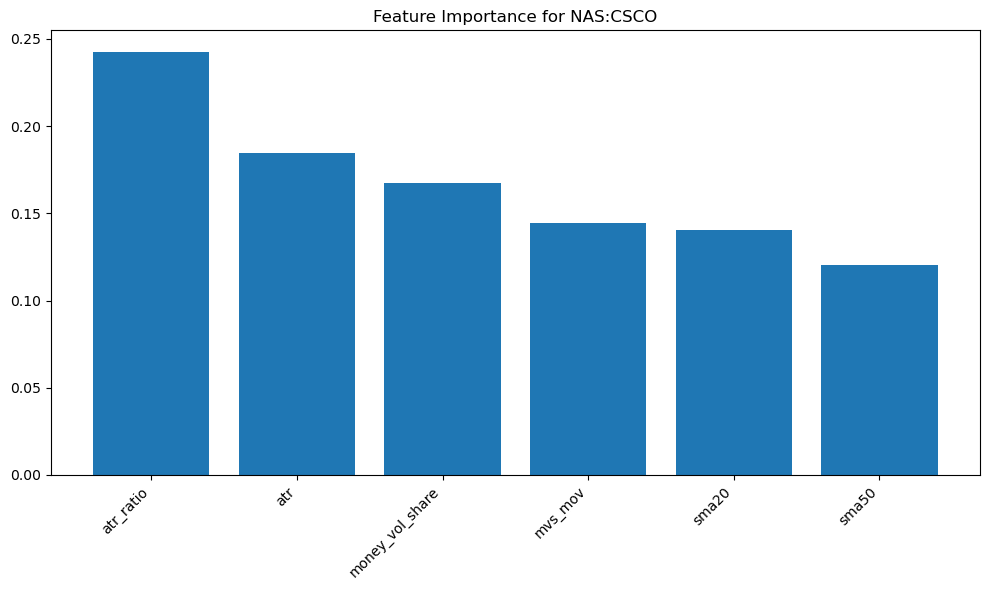


Importancia de características para NYS:GS:
atr_ratio: 0.23110
money_vol_share: 0.19279
atr: 0.17346
mvs_mov: 0.14271
sma20: 0.13398
sma50: 0.12596


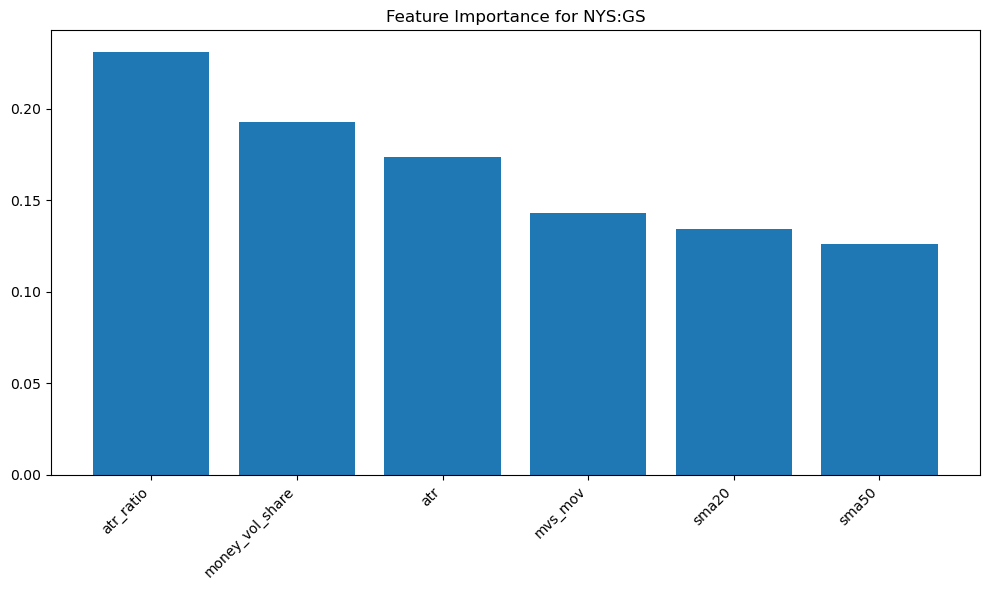


Importancia de características para NYS:JNJ:
atr_ratio: 0.28312
money_vol_share: 0.16950
atr: 0.16792
mvs_mov: 0.13625
sma50: 0.12663
sma20: 0.11659


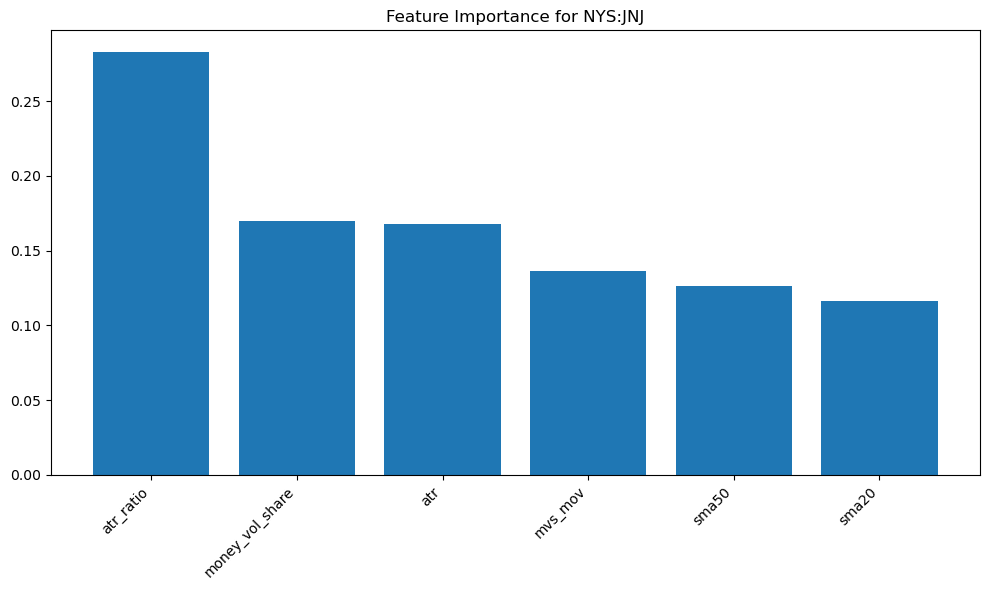

In [7]:
def plot_feature_importance():
    """Visualiza la importancia de las características para cada modelo"""
    for asset_name, model_dict in models.items():
        print(f"\nImportancia de características para {asset_name}:")
        
        # Obtener importancia de características del Random Forest
        importance = model_dict['model'].feature_importances_
        
        # Obtener nombres de las características
        feature_names = list(my_features.field.values)
        
        # Crear DataFrame para mejor visualización
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        # Mostrar valores
        for idx, row in importance_df.iterrows():
            print(f"{row['feature']}: {row['importance']:.5f}")
        
        # Visualización
        plt.figure(figsize=(10, 6))
        plt.bar(importance_df['feature'], importance_df['importance'])
        plt.title(f'Feature Importance for {asset_name}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Mostrar importancia de características
plot_feature_importance()

In [8]:
def generate_weights(data):
    """Genera pesos basados en las predicciones del modelo"""
    # Inicializar pesos
    weights = xr.zeros_like(data.sel(field="close"))
    
    # Calcular features para predicción
    features = get_features(data)
    
    for asset_name, model_dict in models.items():
        try:
            # Obtener y preparar features
            features_cur = features.sel(asset=asset_name).dropna(dim="time", how="any")
            
            if len(features_cur.time) < 1:
                print(f"No hay suficientes datos para {asset_name}")
                continue
                
            # Preparar datos para predicción
            features_array = features_cur.transpose("time", "field").values
            
            # Escalar features
            features_scaled = model_dict['scaler'].transform(features_array)
            
            # Realizar predicción
            predictions = model_dict['model'].predict(features_scaled)
            
            # Solo predicciones positivas (long)
            # predictions_long = np.maximum(predictions, 0)
            # weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = predictions_long

            # Solo predicciones negativas (short)
            # predictions_short = np.minimum(predictions, 0)
            # weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = predictions_short

            # Mantener ambas direcciones
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = predictions
            
        except Exception as e:
            logging.exception(f"Error en predicción para {asset_name}: {str(e)}")
    
    return weights

# Generar pesos
print("Generando predicciones y pesos...")
weights = generate_weights(stock_data)
print("\nResumen de pesos generados:")
print(f"Shape: {weights.shape}")
print("\nEstadísticas descriptivas:")
print(weights.to_pandas().describe())

Generando predicciones y pesos...

Resumen de pesos generados:
Shape: (4954, 20)

Estadísticas descriptivas:
asset     NAS:AAPL     NAS:TSLA     NAS:NVDA     NAS:AMZN     NAS:MSFT  \
count  4954.000000  4954.000000  4954.000000  4954.000000  4954.000000   
mean      0.768483     0.647107     0.723167     0.831263     0.509364   
std       0.348416     0.479437     0.307164     0.297088     0.253306   
min      -0.072262    -0.019404     0.000000     0.000000    -0.111413   
25%       0.497897     0.000000     0.504502     0.629987     0.284395   
50%       0.975319     0.674960     0.708754     0.965847     0.613999   
75%       1.012474     1.160653     0.956593     1.061979     0.695096   
max       1.304609     1.401199     1.277239     1.394053     1.063154   

asset     NAS:META    NAS:GOOGL      NAS:AMD      NYS:BAC      NYS:XOM  \
count  4954.000000  4954.000000  4954.000000  4954.000000  4954.000000   
mean      0.174524     0.835404     0.991607     0.957226     0.565194   
st


Métricas de rendimiento:
Sharpe Ratio: 0.70
Maximum Drawdown: -13.14%
Volatility: 1.59%


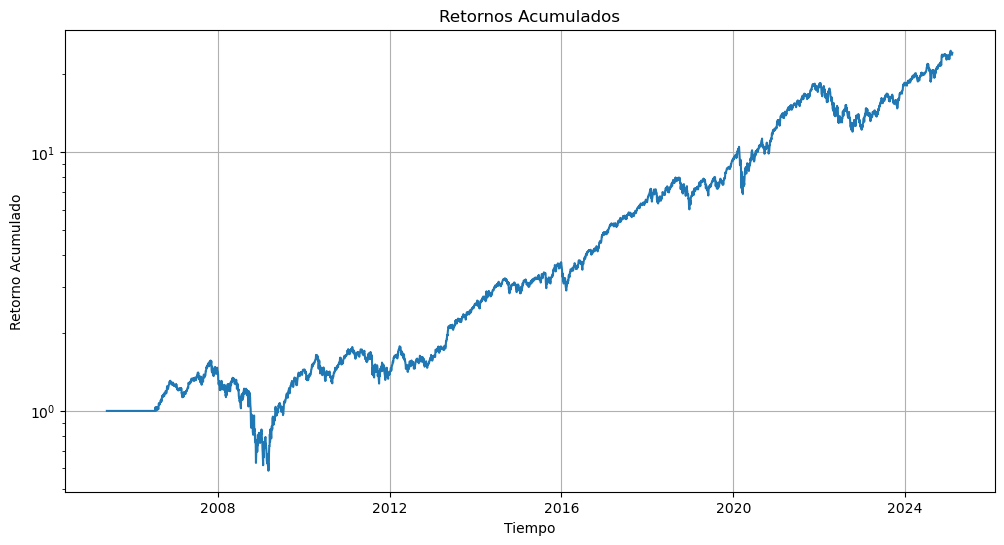

In [9]:
def calculate_metrics(data, weights):
    """Calcula múltiples métricas de rendimiento"""
    try:
        # Calcular retornos relativos
        returns = qnstats.calc_relative_return(data, weights)
        
        # Calcular Sharpe Ratio
        sharpe = qnstats.calc_sharpe_ratio_annualized(returns).values[-1]
        
        # Calcular máximo drawdown
        max_dd = qnstats.calc_max_drawdown(returns).values[-1]
        
        # Calcular volatilidad
        volatility = qnstats.calc_volatility(returns).values[-1]
        
        print("\nMétricas de rendimiento:")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        print(f"Maximum Drawdown: {max_dd:.2%}")
        print(f"Volatility: {volatility:.2%}")
        
        return {
            'sharpe': sharpe,
            'max_drawdown': max_dd,
            'volatility': volatility
        }
        
    except Exception as e:
        logging.exception("Error calculando métricas")
        return None

# Calcular y mostrar métricas
metrics = calculate_metrics(stock_data, weights)
if metrics:
    # Visualizar retornos acumulados
    returns = qnstats.calc_relative_return(stock_data, weights)
    cumulative_returns = (1 + returns).cumprod()
    
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns.time, cumulative_returns)
    plt.title('Retornos Acumulados')
    plt.xlabel('Tiempo')
    plt.ylabel('Retorno Acumulado')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

In [10]:
qnout.write(weights)

Write output: /root/fractions.nc.gz



Análisis de Portafolio con Capital Inicial: $1,000,000.00
------------------------------------------------------------
Valor Final del Portafolio: $24,199,950.03
Retorno Total: 2320.00%

Contribución por Activo:
------------------------------------------------------------
NAS:AMZN:
  Contribución: $69,815,520.54
  % del Retorno Total: 300.93%
NAS:AAPL:
  Contribución: $61,173,789.54
  % del Retorno Total: 263.68%
NAS:NFLX:
  Contribución: $48,290,129.74
  % del Retorno Total: 208.15%
NAS:TSLA:
  Contribución: $42,773,691.76
  % del Retorno Total: 184.37%
NAS:NVDA:
  Contribución: $33,876,445.92
  % del Retorno Total: 146.02%
NAS:GOOGL:
  Contribución: $16,971,993.54
  % del Retorno Total: 73.16%
NYS:JNJ:
  Contribución: $7,372,767.72
  % del Retorno Total: 31.78%
NAS:MSFT:
  Contribución: $4,999,166.79
  % del Retorno Total: 21.55%
NAS:AMD:
  Contribución: $2,716,458.47
  % del Retorno Total: 11.71%
NAS:GOOG:
  Contribución: $2,526,316.03
  % del Retorno Total: 10.89%
NAS:CSCO:
  Cont

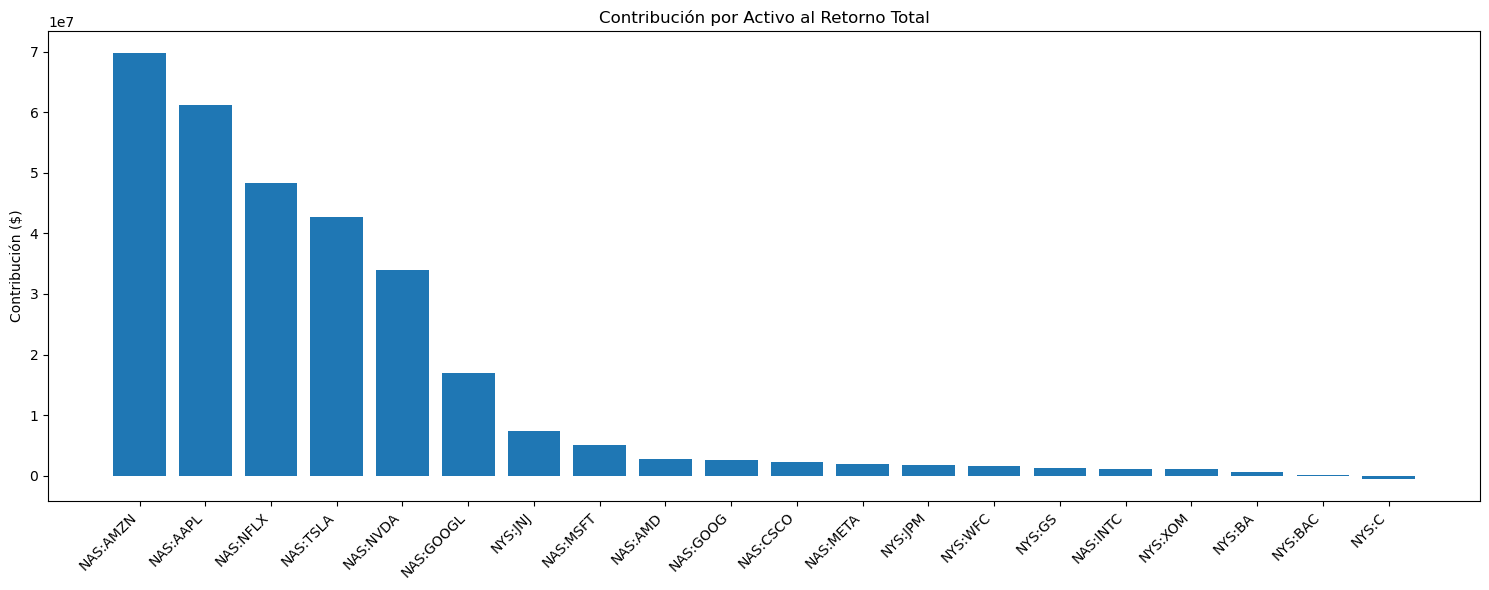

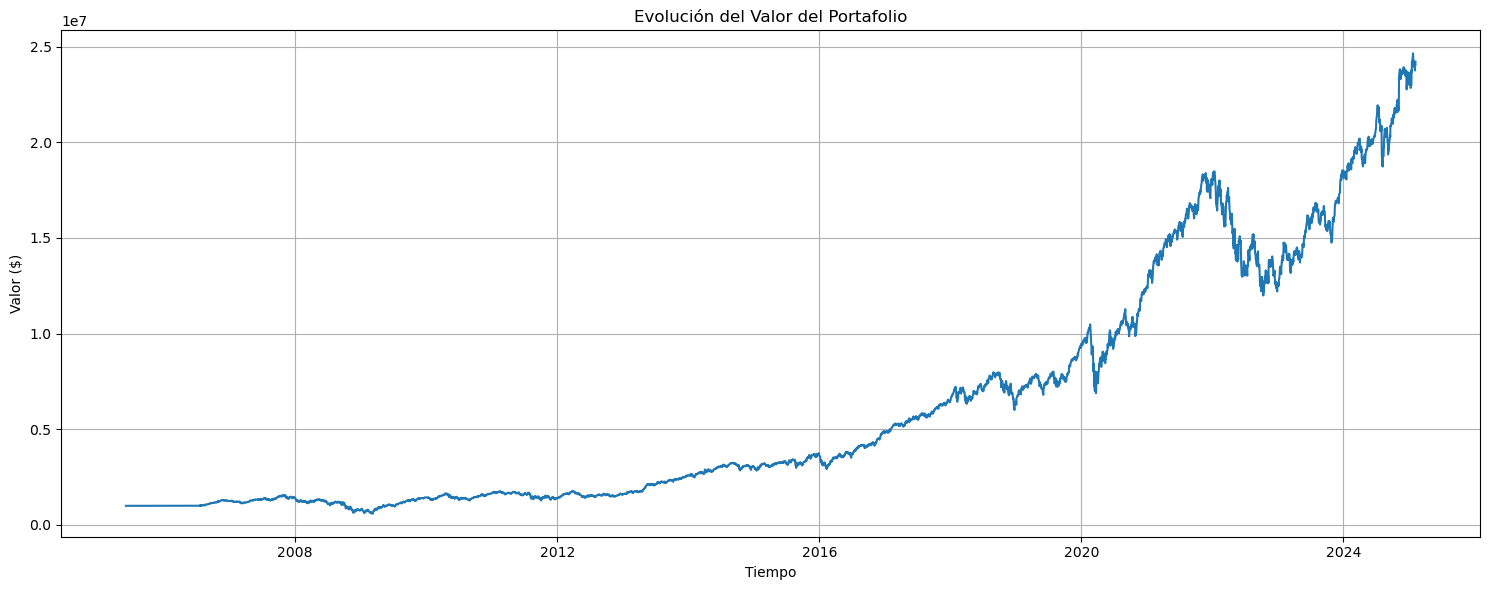

In [11]:
def calculate_portfolio_performance(data, weights, initial_capital=1_000_000):
    """Calcula el rendimiento del portafolio y la contribución por activo"""
    try:
        # Calcular retornos relativos
        returns = qnstats.calc_relative_return(data, weights)
        
        # Calcular equity curve (valor del portafolio en el tiempo)
        portfolio_value = initial_capital * (1 + returns).cumprod()
        
        # Calcular retornos por activo
        asset_returns = {}
        final_values = {}
        contributions = {}
        
        for asset in weights.asset.values:
            # Crear pesos solo para este activo
            single_asset_weights = xr.zeros_like(weights)
            single_asset_weights.loc[dict(asset=asset)] = weights.sel(asset=asset)
            
            # Calcular retornos para este activo
            asset_return = qnstats.calc_relative_return(data, single_asset_weights)
            asset_value = initial_capital * (1 + asset_return).cumprod()
            
            asset_returns[asset] = asset_return
            final_values[asset] = float(asset_value.isel(time=-1))
            contributions[asset] = final_values[asset] - initial_capital
        
        # Ordenar contribuciones por valor
        sorted_contributions = dict(sorted(contributions.items(), key=lambda x: x[1], reverse=True))
        
        # Mostrar resultados
        final_portfolio_value = float(portfolio_value.isel(time=-1))
        total_return = ((final_portfolio_value - initial_capital) / initial_capital) * 100
        
        print(f"\nAnálisis de Portafolio con Capital Inicial: ${initial_capital:,.2f}")
        print("-" * 60)
        print(f"Valor Final del Portafolio: ${final_portfolio_value:,.2f}")
        print(f"Retorno Total: {total_return:.2f}%")
        
        print("\nContribución por Activo:")
        print("-" * 60)
        for asset, contribution in sorted_contributions.items():
            pct_contribution = (contribution / (final_portfolio_value - initial_capital)) * 100
            print(f"{asset}:")
            print(f"  Contribución: ${contribution:,.2f}")
            print(f"  % del Retorno Total: {pct_contribution:.2f}%")
        
        # Visualización
        plt.figure(figsize=(15, 6))
        plt.bar(sorted_contributions.keys(), sorted_contributions.values())
        plt.title('Contribución por Activo al Retorno Total')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Contribución ($)')
        plt.tight_layout()
        plt.show()
        
        # Gráfica de evolución del valor del portafolio
        plt.figure(figsize=(15, 6))
        plt.plot(portfolio_value.time, portfolio_value)
        plt.title('Evolución del Valor del Portafolio')
        plt.xlabel('Tiempo')
        plt.ylabel('Valor ($)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        return {
            'final_value': final_portfolio_value,
            'total_return': total_return,
            'contributions': sorted_contributions
        }
        
    except Exception as e:
        logging.exception("Error en el cálculo del rendimiento del portafolio")
        return None

# Calcular y mostrar el rendimiento del portafolio
portfolio_analysis = calculate_portfolio_performance(stock_data, weights, initial_capital=1_000_000)